# Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 326kB/s 
     |████████████████████████████████| 2.2MB 12.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-any.whl size=44419 sha256=aba3020a452b1f621f677f9ce1f7a29616999c370cb9a9c4316674a73221d9f3
  Stored in directory: /root/.cache/pip/wheels/ec/4d/40/4077356fe02ef345791713eabede5ed63afe7d613b016694d1
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


## Get data

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# !wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
# !unzip microcontroller_segmentation_data.zip
# !ls

In [2]:
#Testing if the dataset is present and the subfolders are present as desired

!ls {DATASET_DIR}

input  test  train  val


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [3]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("mechanics_train", {}, DATASET_DIR + "/train/coco_instances.json", DATASET_DIR + "/train/images")
register_coco_instances("mechanics_val", {}, DATASET_DIR + "/val/coco_instances.json", DATASET_DIR"/val/images")

[11/04 11:42:12 d2.data.datasets.coco]: Loaded 10000 images in COCO format from /content/drive/My Drive/CS DOP/mechanics_dataset_2/train/coco_instances.json


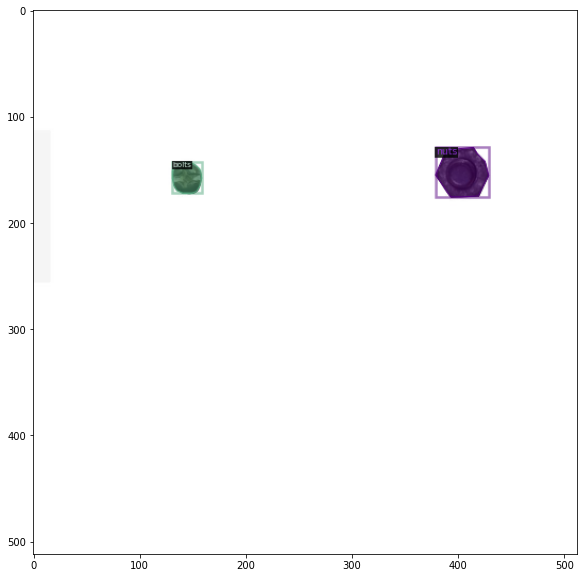

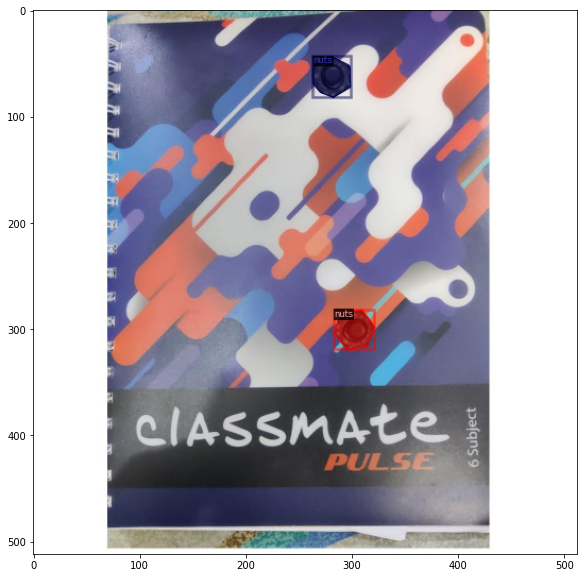

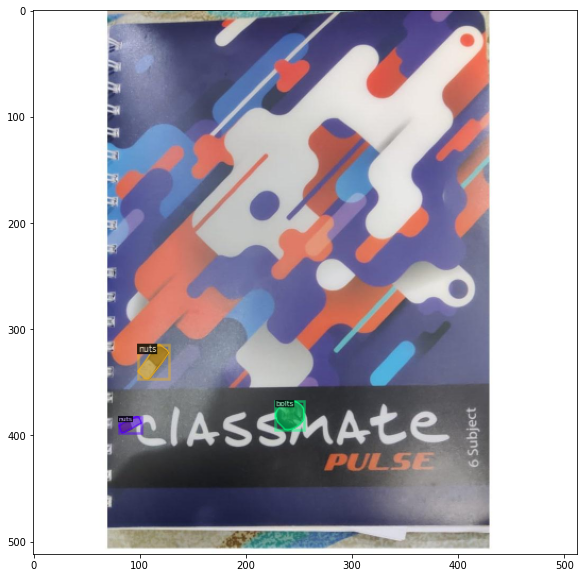

In [5]:
# Visualize the dataset by randomly choosing few images and displaying them with their masks

import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("mechanics_train")
microcontroller_metadata = MetadataCatalog.get("mechanics_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the data-set.

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mechanics_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/04 11:50:35 d2.utils.events]:  eta: 0:21:29  iter: 519  total_loss: 0.502  loss_cls: 0.158  loss_box_reg: 0.259  loss_mask: 0.088  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 0.8828  data_time: 0.5097  lr: 0.000130  max_mem: 2195M
[11/04 11:50:52 d2.utils.events]:  eta: 0:21:11  iter: 539  total_loss: 0.646  loss_cls: 0.214  loss_box_reg: 0.285  loss_mask: 0.110  loss_rpn_cls: 0.003  loss_rpn_loc: 0.006  time: 0.8819  data_time: 0.4806  lr: 0.000135  max_mem: 2195M
[11/04 11:51:10 d2.utils.events]:  eta: 0:20:52  iter: 559  total_loss: 0.614  loss_cls: 0.212  loss_box_reg: 0.294  loss_mask: 0.088  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.8817  data_time: 0.4871  lr: 0.000140  max_mem: 2195M
[11/04 11:51:27 d2.utils.events]:  eta: 0:20:34  iter: 579  total_loss: 0.491  loss_cls: 0.151  loss_box_reg: 0.236  loss_mask: 0.085  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.8813  data_time: 0.5120  lr: 0.000145  max_mem: 2195M
[11/04 11:51:45 d2.utils.events]:  eta: 0:20

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[11/04 12:12:16 d2.engine.train_loop]: Starting training from iteration 0
[11/04 12:12:29 d2.utils.events]:  eta: 0:19:12  iter: 19  total_loss: 3.015  loss_cls: 1.985  loss_box_reg: 0.281  loss_mask: 0.695  loss_rpn_cls: 0.008  loss_rpn_loc: 0.004  time: 0.6034  data_time: 0.1207  lr: 0.000005  max_mem: 2320M
[11/04 12:12:43 d2.utils.events]:  eta: 0:19:11  iter: 39  total_loss: 2.787  loss_cls: 1.809  loss_box_reg: 0.233  loss_mask: 0.690  loss_rpn_cls: 0.004  loss_rpn_loc: 0.005  time: 0.6475  data_time: 0.2368  lr: 0.000010  max_mem: 2320M
[11/04 12:12:56 d2.utils.events]:  eta: 0:18:59  iter: 59  total_loss: 2.392  loss_cls: 1.389  loss_box_reg: 0.236  loss_mask: 0.677  loss_rpn_cls: 0.023  loss_rpn_loc: 0.003  time: 0.6489  data_time: 0.1677  lr: 0.000015  max_mem: 2320M
[11/04 12:13:10 d2.utils.events]:  eta: 0:19:02  iter: 79  total_loss: 1.759  loss_cls: 0.847  loss_box_reg: 0.187  loss_mask: 0.669  loss_rpn_cls: 0.015  loss_rpn_loc: 0.005  time: 0.6650  data_time: 0.2869  lr:

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("mechanics_val",)
predictor = DefaultPredictor(cfg)

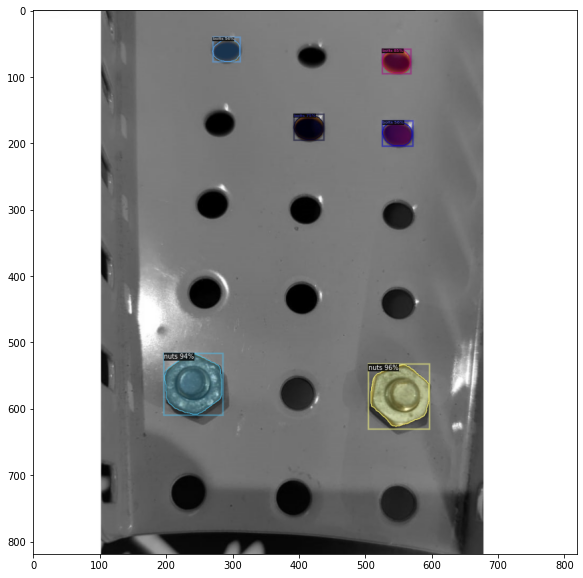

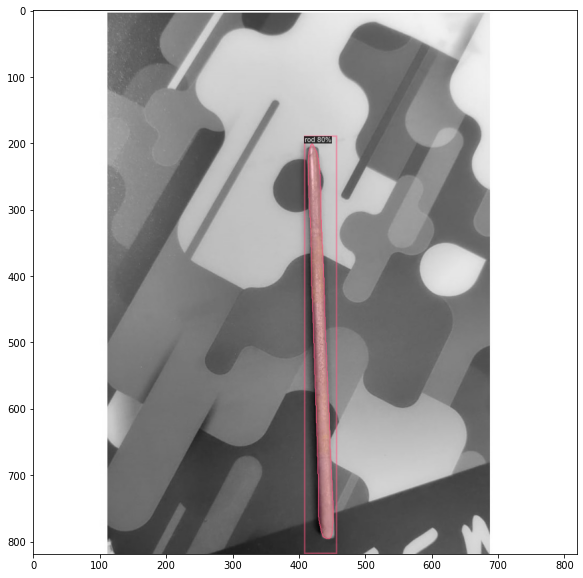

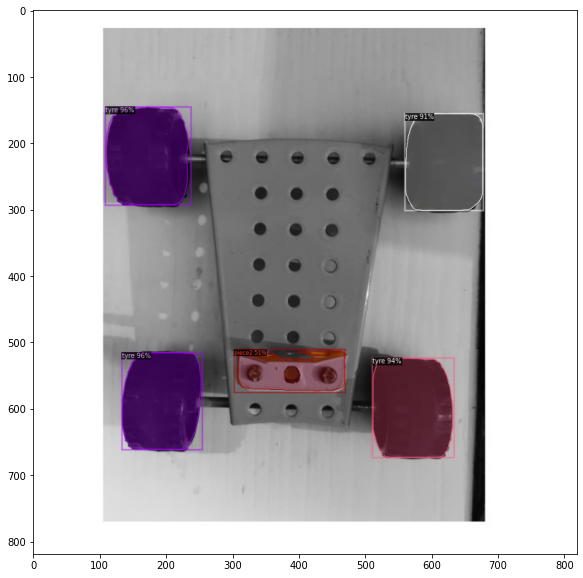

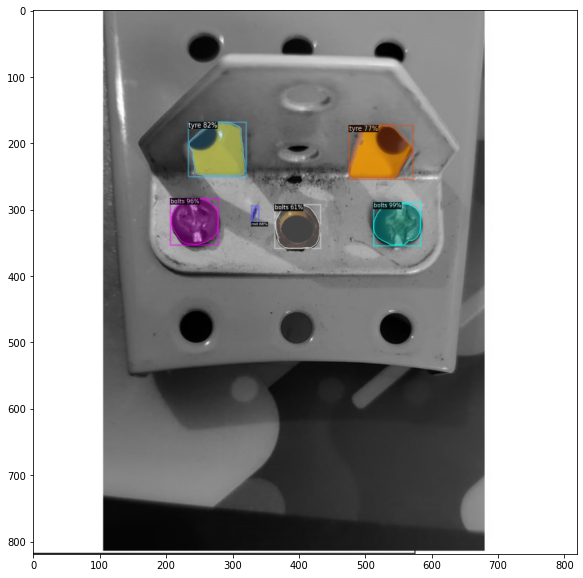

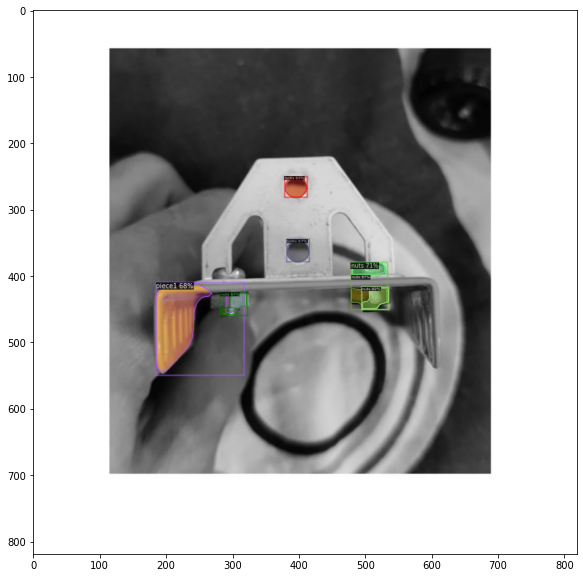

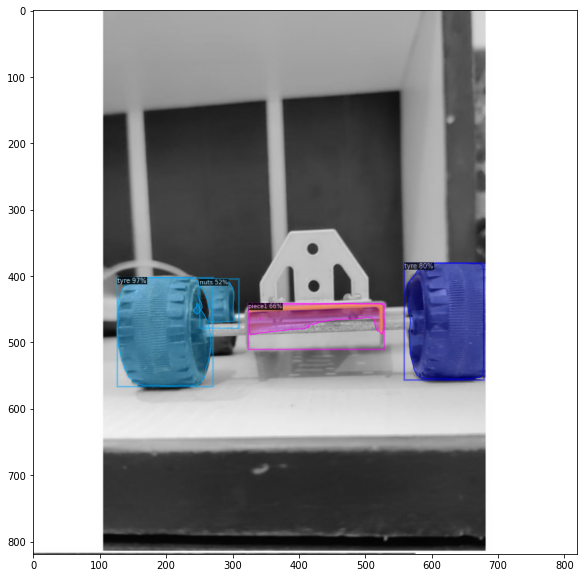

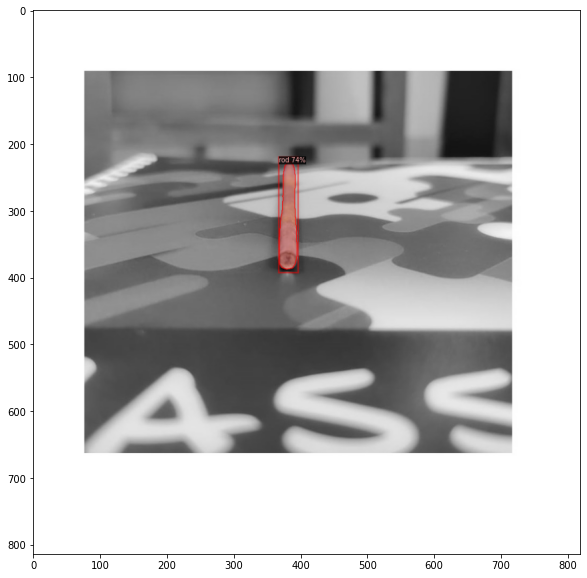

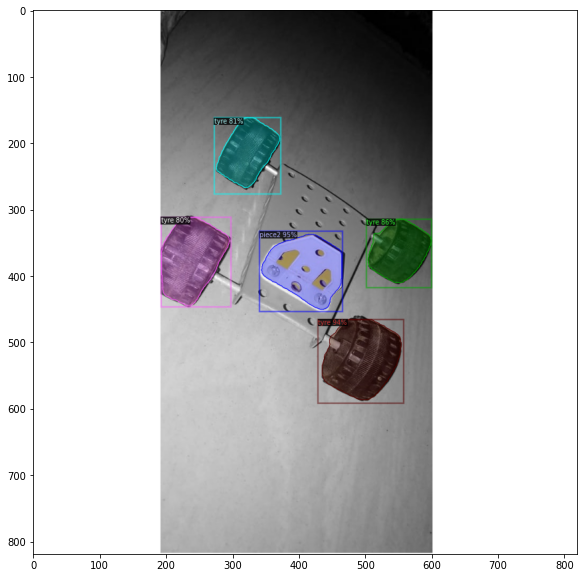

In [9]:
# Testing the trained model on Actual Test Images

from detectron2.utils.visualizer import ColorMode
# dataset_dicts = DatasetCatalog.get("mechanics_val")
# for d in random.sample(dataset_dicts, 3):
image_paths = IMAGES_PATH
# im = cv2.imread(d["file_name"])
for i in range(1,9):
    im = cv2.imread('{0}pic{1}.jpeg'.format(image_paths, i))
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=microcontroller_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()